In [1]:
!pip install datasets
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=2c15f1941614b5fb0ce0b5d92a60e1816ae65f3169746afdab8bd19f87f8dfa0
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [2]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from seqeval.metrics import classification_report
from transformers import EarlyStoppingCallback

# Load the data
df = pd.read_csv('/kaggle/input/sentence-data-ner/sentence_level_ner_data.csv')

# Convert the data into the format required by the Hugging Face datasets library
def convert_to_hf_format(df):
    tokens = []
    labels = []
    
    for _, row in df.iterrows():
        tokens.append(eval(row['Tokens']))  # Ensure the stringified list is evaluated back to a list
        labels.append(eval(row['ner_tags']))  # Same for labels (string to list conversion)
    
    return tokens, labels

tokens, labels = convert_to_hf_format(df)

# Debug prints to check the data
print(f"Number of samples: {len(tokens)}")
print(f"First sample tokens: {tokens[0] if tokens else 'No tokens'}")
print(f"First sample labels: {labels[0] if labels else 'No labels'}")

# Create a Hugging Face dataset
dataset = Dataset.from_dict({"Tokens": tokens, "ner_tags": labels})

# Check the dataset
print(dataset)

# Split the dataset into train and test sets
if len(tokens) > 1:
    dataset = dataset.train_test_split(test_size=0.2)
else:
    raise ValueError("Not enough samples to split into train and test sets.")

# Define the label list
label_list = ["O", "B-START", "I-START", "B-END", "I-END"]

# Load the tokenizer and model
model_name = "cmarkea/distilcamembert-base-ner"  # CamemBERT model for French NER
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(label_list))

# Tokenize the dataset and align labels
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["Tokens"], truncation=True, is_split_into_words=True, padding="max_length", max_length=128)
    
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:  # Padding token
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first subword
                label_ids.append(label[word_idx])
            else:  # Subword tokens will be ignored (-100)
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Apply the tokenization function to the entire dataset
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

# Define the data collator
data_collator = DataCollatorForTokenClassification(tokenizer)

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

# Define the metrics function for the trainer
def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(axis=-1)
    
    # Remove ignored index (-100) and convert back to string labels
    true_labels = [[label_list[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    # Use seqeval's classification report to compute precision, recall, f1
    report = classification_report(true_labels, true_predictions, output_dict=True)
    return report

# Initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
trainer.train()

# Save the model and tokenizer
model.save_pretrained("./ner_model")
tokenizer.save_pretrained("./ner_model")


Number of samples: 99186
First sample tokens: ['Y', 'a-t-il', 'des', 'réductions', 'pour', 'les', 'billets', 'de', 'Orléans', 'à', 'Bezier', '?']
First sample labels: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0]
Dataset({
    features: ['Tokens', 'ner_tags'],
    num_rows: 99186
})


tokenizer_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/945 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/270M [00:00<?, ?B/s]

Map:   0%|          | 0/79348 [00:00<?, ? examples/s]

Map:   0%|          | 0/19838 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,End,Start,Micro avg,Macro avg,Weighted avg
1,0.000200,0.000136,"{'precision': 0.9998655913978495, 'recall': 1.0, 'f1-score': 0.999932791182203, 'support': 14878}","{'precision': 1.0, 'recall': 0.9998787805321535, 'f1-score': 0.9999393865923143, 'support': 16499}","{'precision': 0.9999362590432482, 'recall': 0.9999362590432482, 'f1-score': 0.9999362590432482, 'support': 31377}","{'precision': 0.9999327956989248, 'recall': 0.9999393902660767, 'f1-score': 0.9999360888872586, 'support': 31377}","{'precision': 0.9999362676105811, 'recall': 0.9999362590432482, 'f1-score': 0.9999362592534472, 'support': 31377}"
2,0.000100,0.000112,"{'precision': 0.9998655913978495, 'recall': 1.0, 'f1-score': 0.999932791182203, 'support': 14878}","{'precision': 0.9999393865923142, 'recall': 0.9998787805321535, 'f1-score': 0.9999090826438767, 'support': 16499}","{'precision': 0.9999043916119574, 'recall': 0.9999362590432482, 'f1-score': 0.9999203250736994, 'support': 31377}","{'precision': 0.9999024889950818, 'recall': 0.9999393902660767, 'f1-score': 0.9999209369130398, 'support': 31377}","{'precision': 0.999904395200427, 'recall': 0.9999362590432482, 'f1-score': 0.9999203244972477, 'support': 31377}"
3,0.000000,0.000104,"{'precision': 0.9999327911822031, 'recall': 1.0, 'f1-score': 0.9999663944618074, 'support': 14878}","{'precision': 1.0, 'recall': 0.9999393902660767, 'f1-score': 0.9999696942146256, 'support': 16499}","{'precision': 0.9999681295216242, 'recall': 0.9999681295216242, 'f1-score': 0.9999681295216242, 'support': 31377}","{'precision': 0.9999663955911016, 'recall': 0.9999696951330383, 'f1-score': 0.9999680443382164, 'support': 31377}","{'precision': 0.9999681316636014, 'recall': 0.9999681295216242, 'f1-score': 0.9999681295742066, 'support': 31377}"


Trainer is attempting to log a value of "{'precision': 0.9998655913978495, 'recall': 1.0, 'f1-score': 0.999932791182203, 'support': 14878}" of type <class 'dict'> for key "eval/END" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 1.0, 'recall': 0.9998787805321535, 'f1-score': 0.9999393865923143, 'support': 16499}" of type <class 'dict'> for key "eval/START" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9999362590432482, 'recall': 0.9999362590432482, 'f1-score': 0.9999362590432482, 'support': 31377}" of type <class 'dict'> for key "eval/micro avg" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9999327956989248, 'recall': 0.999939390266076

('./ner_model/tokenizer_config.json',
 './ner_model/special_tokens_map.json',
 './ner_model/sentencepiece.bpe.model',
 './ner_model/added_tokens.json',
 './ner_model/tokenizer.json')

Trainer is attempting to log a value of "{'precision': 0.9999327911822031, 'recall': 1.0, 'f1-score': 0.9999663944618074, 'support': 14878}" of type <class 'dict'> for key "eval/END" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 1.0, 'recall': 0.9999393902660767, 'f1-score': 0.9999696942146256, 'support': 16499}" of type <class 'dict'> for key "eval/START" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9999681295216242, 'recall': 0.9999681295216242, 'f1-score': 0.9999681295216242, 'support': 31377}" of type <class 'dict'> for key "eval/micro avg" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9999663955911016, 'recall': 0.99996969513303

{'eval_loss': 0.00010434404975967482, 'eval_END': {'precision': 0.9999327911822031, 'recall': 1.0, 'f1-score': 0.9999663944618074, 'support': 14878}, 'eval_START': {'precision': 1.0, 'recall': 0.9999393902660767, 'f1-score': 0.9999696942146256, 'support': 16499}, 'eval_micro avg': {'precision': 0.9999681295216242, 'recall': 0.9999681295216242, 'f1-score': 0.9999681295216242, 'support': 31377}, 'eval_macro avg': {'precision': 0.9999663955911016, 'recall': 0.9999696951330383, 'f1-score': 0.9999680443382164, 'support': 31377}, 'eval_weighted avg': {'precision': 0.9999681316636014, 'recall': 0.9999681295216242, 'f1-score': 0.9999681295742066, 'support': 31377}, 'eval_runtime': 58.9462, 'eval_samples_per_second': 336.544, 'eval_steps_per_second': 10.518, 'epoch': 3.0}


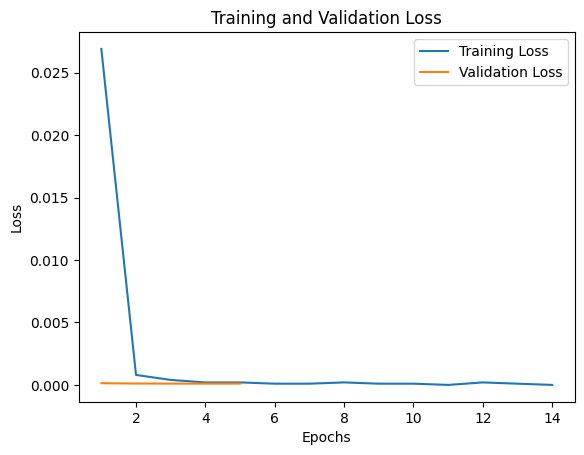

In [4]:
import matplotlib.pyplot as plt
# Evaluate the model with test data
eval_results = trainer.evaluate(tokenized_datasets["test"])

# Access the training and validation loss from the log history
training_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
validation_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Ensure that epochs correspond to the length of the losses
epochs = range(1, len(training_loss) + 1)

# Print the evaluation results
print(eval_results)

# Create the plot
plt.plot(epochs, training_loss, label='Training Loss')

epochs = range(1, len(validation_loss) + 1)
plt.plot(epochs, validation_loss, label='Validation Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# Add a legend
plt.legend()

# Show the plot
plt.show()